In [1]:
%matplotlib inline

In [2]:
import gym
import math
import random
import tqdm
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from IPython.display import clear_output
from collections import namedtuple
from collections import deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display    
print("Is python : {}".format(is_ipython))

device_id = 2
device = torch.device(('cuda:%d' % device_id) if torch.cuda.is_available() else "cpu")
print("Device : {}".format(device))

env = gym.make('Breakout-v0').unwrapped
ACTIONS_NUM = env.action_space.n
print("Number of actions : {}".format(ACTIONS_NUM))

Is python : True
Device : cuda:2
Number of actions : 4


In [3]:
STATE_SIZE = 4
STATE_W = 84
STATE_H = 84
MEMSIZE = 100000

# Задание 1. Необходимо реализовать класс для хранения состояния игры. 
# В качестве последнего мы будем использовать состеканные 4 последовательных кадра игры.
# Это необходимо, чтобы агент понимал скорости и ускорения игровых объектов.
class StateHolder:
    def __init__(self, screen):
        self.frames = deque(maxlen = STATE_SIZE)
        for _ in range(STATE_SIZE):
            self.frames.append(screen)
        
    def reset(self):
        self.frames.clear()
    
    def push(self, frame):
        self.frames.append(frame)
        
    def get(self):
        # SLOW - !
        # frames = tuple(frame.type(torch.cuda.FloatTensor) for frame in self.frames)
        return torch.cat(tuple(self.frames), dim = 0).unsqueeze_(0)
    
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory:

    def __init__(self):
        self.memory = deque(maxlen = MEMSIZE)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [4]:
# Задание 2. Собрать архитектуру сети (DQN).

class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=1, stride=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=4, stride=2)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=2)
        self.lin1 = nn.Linear(128*4*4, 512)
        self.lin2 = nn.Linear(512, ACTIONS_NUM)
        
        gain = nn.init.calculate_gain('relu')
        nn.init.xavier_normal_(self.conv1.weight, gain)
        nn.init.xavier_normal_(self.conv2.weight, gain)
        nn.init.xavier_normal_(self.conv3.weight, gain)
        nn.init.xavier_normal_(self.conv4.weight, gain)
        nn.init.xavier_normal_(self.lin1.weight, gain)
        nn.init.xavier_normal_(self.lin2.weight)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return x

In [5]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize( (STATE_W, STATE_H), interpolation=Image.CUBIC),
                    T.ToTensor()])

def get_screen(env):
    screen = env.render(mode='rgb_array')
    screen = np.dot(screen[...,:3], [0.299, 0.587, 0.114])
    screen = screen[30:195,:]
    screen = np.ascontiguousarray(screen, dtype=np.uint8).reshape(screen.shape[0],screen.shape[1],1)
    return resize(screen).mul(255).type(torch.ByteTensor).to(device).detach()

def show_state(env, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("%s | Step: %d %s" % (env.spec.id, step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())

In [6]:
policy_net = DQN().to(device)
target_net = DQN().to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters(), lr=0.0001, alpha=0.95)

def btf(tensor):
    # ByteTesnor -> FloatTensor
    return tensor.type(torch.cuda.FloatTensor).to(device)

def select_action(state, eps_threshold):
    sample = random.random()
    if sample > eps_threshold:
        with torch.no_grad():
            output = policy_net(btf(state))
            return output.max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(ACTIONS_NUM)]], device=device, dtype=torch.long)

train_rewards = []

mean_size = 100
mean_step = 1

def plot_rewards(rewards = train_rewards, name = "Train"):
    plt.figure(2)
    plt.clf()
    plt.title(name)
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(rewards)
    # Строим график среднего вознаграждения по 100 последним эпизодам
    if len(rewards) > mean_size:
        means = np.array([rewards[i:i+mean_size:] for i in range(0, len(rewards) - mean_size, mean_step)]).mean(1)
        means = np.concatenate((np.zeros(mean_size - 1), means))
        plt.plot(means)

In [7]:
BATCH_SIZE = 32
GAMMA = 0.99

def optimize_model(memory):
    if len(memory) < BATCH_SIZE:
        return
    # выбираем новый батч
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    # Для всех состояний считаем маску не финальнсти и конкантенируем их
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.uint8)

    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Считаем Q(s_t, a) - модель дает Q(s_t), затем мы выбираем
    # колонки, которые соответствуют нашим действиям на шаге
    
    state_action_values = policy_net(btf(state_batch)).gather(1, action_batch)

    # Подсчитываем ценность состяония V(s_{t+1}) для всех последующмх состояний.
    next_state_values = torch.zeros(BATCH_SIZE, device=device).detach()
    next_state_values[non_final_mask] = target_net(btf(non_final_next_states)).max(1)[0].detach() # берем значение максимума
    
    # Считаем ожидаемое значение функции оценки ценности действия  Q-values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    
    # Считаем ошибку Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze_(1))
    
    # Оптимизация модели
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()
    
    del non_final_mask
    del non_final_next_states
    del state_batch
    del action_batch
    del reward_batch
    del state_action_values
    del next_state_values
    del expected_state_action_values
    del loss

Episodes played: 6617; Steps done : 3619554; Eps threshold: 0.1
Episode score : 53.0
Mean score : 35.08


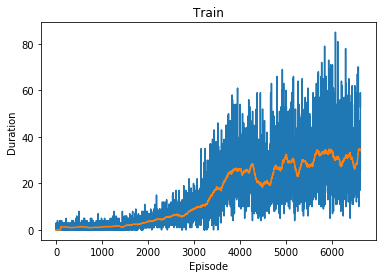

In [8]:
NUM_EPISODES = 100000
OPTIMIZE_MODEL_STEP = 5
FRAME_SKIPPING_STEP = 4
TARGET_UPDATE=10000
STEPS_BEFORE_TRAIN = 10000

# параметры для e-greedy
EPS_START = 1
EPS_END = 0.1
EPS_DECAY = 1000000
EPS_STEP = (EPS_START - EPS_END) / EPS_DECAY
eps_threshold = EPS_START

policy_net.train()
target_net.eval()

test_rewards = []
replay_memory = ReplayMemory()

env = gym.make('Breakout-v0').unwrapped
env.frameskip = FRAME_SKIPPING_STEP
steps_done = 0
mean_score = 0

# Задание 3. Заполнить пропуски в нижеприведенном коде.

for e in tqdm.tqdm_notebook(range(NUM_EPISODES)):
    
    ep_rewards = []
    env.reset()
    lives = env.ale.lives()
    
    state_holder = StateHolder(get_screen(env))
    state = state_holder.get()
    
    if mean_score > 35:
        plot_rewards()
        break 
    
    for t in count():
        
        if steps_done > EPS_DECAY:
            eps_threshold = EPS_END
        else:
            eps_threshold -= EPS_STEP
        steps_done+=1
        
        action = select_action(state, eps_threshold)
        
        # Применим выбранное действие к нескольким последовательным кадрам
        _, reward, done, info = env.step(action.item())
        ep_rewards.append(reward)
        state_holder.push(get_screen(env))
        
        if done:
            reward = -1
            next_state = None
        elif info['ale.lives'] < lives:
            lives -= 1
            reward = -1
            next_state = None
        else:
            next_state = state_holder.get()
        
        replay_memory.push(state, action, next_state, torch.Tensor([reward]).to(device))
        state = state_holder.get() if reward == -1 else next_state
             
        
        if (steps_done > STEPS_BEFORE_TRAIN) and steps_done % OPTIMIZE_MODEL_STEP == 0:
            optimize_model(replay_memory)
        
        if steps_done % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())
        
        if done:
            clear_output(wait=True)
            score = np.sum(ep_rewards)
            train_rewards.append(score)
            print("Episodes played: {}; Steps done : {}; Eps threshold: {}"
                  .format(e, steps_done, eps_threshold))
            print("Episode score : {}".format(score))
            mean_score = np.mean(train_rewards[-100:])
            print("Mean score : {}".format(mean_score))

            break

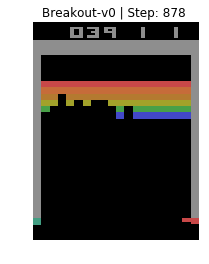

Total game reward : 39.0


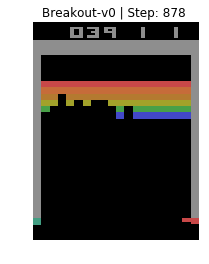

In [9]:
# Задание 4. Просто выполнить данную ячейку и проверить вашего агента - насколько он хорош!?

TEST_EPS = 0.05

policy_net.eval()
env.reset()
state_holder = StateHolder(get_screen(env))

total_reward = 0

for i in count():
    # Выбрать и выполнить нове действие
    action = select_action(state_holder.get(), TEST_EPS)
    _, reward, done, _ = env.step(action.item())
    total_reward += reward
    # Получаем новое состояние
    if not done:
        state_holder.push(get_screen(env))
    else:
        break
    show_state(env, i)
    
print("Total game reward : {}".format(total_reward))